# Machine Learning Models for SCOPE: Passive Aggressive Classifier
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils

logs = pd.read_csv("data/metis_logs.csv")
logs.head()

In [2]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
logs['is_alert'].describe()

count    9674.000000
mean        0.166425
std         0.372481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_alert, dtype: float64

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(AS_data.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_TS = utils.data_prep_pipeline(TS_data.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'])

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

In [ ]:
valid_AS['min_max'].head()

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Modelling
Now that all the data is prepped, we can start building some logistic regression models to test on. We also need to split our data into a test and train set being careful that we have an equal proportion of anomalies in each (because they are very few, we have to make sure we don't train or test the model on all the anomalies while the other gets none).

### Split Data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# scaling method to test
AS_scaler = 'min_max'
TS_scaler = 'min_max'
RexT_scaler = 'min_max'

# separate out data into feature matrices and target arrays
AS_features = valid_AS[AS_scaler][[col for col in valid_AS[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_targets = valid_AS[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_features = valid_TS[TS_scaler][[col for col in valid_TS[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]]
TS_targets = valid_TS[TS_scaler]['is_alert']

RexT_features = valid_RexT[RexT_scaler][[col for col in valid_RexT[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_targets = valid_RexT[RexT_scaler]['is_alert']
test_RexT_features = RexT_features.drop(columns=[col for col in RexT_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# split into a train and test set 
AS_X_train, AS_X_test, AS_y_train, AS_y_test = train_test_split(AS_features[[col for col in AS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                AS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
TS_X_train, TS_X_test, TS_y_train, TS_y_test = train_test_split(TS_features[[col for col in TS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                TS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
RexT_X_train, RexT_X_test, RexT_y_train, RexT_y_test = train_test_split(test_RexT_features[[col for col in 
                                                                                            test_RexT_features.columns
                                                                                            if 'diff' not in col]], 
                                                                        RexT_targets, 
                                                                        test_size=0.5, 
                                                                        random_state=25)

Let's make sure that we have similar percentage of anomalies in our test and train sets. 

In [19]:
# AS
print('Total alerts in training set: ' + str(AS_y_train.sum()))
print('Total alerts in test set: ' + str(AS_y_test.sum()))
pd.DataFrame({'train' : AS_y_train.value_counts(normalize=True), 
              'test' : AS_y_test.value_counts(normalize=True)})

Total alerts in training set: 958.0
Total alerts in test set: 262.0


,test,train
0.0,0.770979,0.790647
1.0,0.229021,0.209353


In [20]:
# TS
print('Total alerts in training set: ' + str(TS_y_train.sum()))
print('Total alerts in test set: ' + str(TS_y_test.sum()))
pd.DataFrame({'train' : TS_y_train.value_counts(normalize=True), 
              'test' : TS_y_test.value_counts(normalize=True)})

Total alerts in training set: 224.0
Total alerts in test set: 76.0


,test,train
0.0,0.891429,0.92
1.0,0.108571,0.08


In [21]:
# RexT
print('Total alerts in training set: ' + str(RexT_y_train.sum()))
print('Total alerts in test set: ' + str(RexT_y_test.sum()))
pd.DataFrame({'train' : RexT_y_train.value_counts(normalize=True), 
              'test' : RexT_y_test.value_counts(normalize=True)})

Total alerts in training set: 9.0
Total alerts in test set: 13.0


,test,train
0.0,0.868687,0.909091
1.0,0.131313,0.090909


### Passive Aggressive Classifier without Differences
**Rough idea**:
- Passive: if correct classification, keep the model
- Aggressive: if incorrect classification, update to adjust to this misclassified example.

In [22]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

pac = PassiveAggressiveClassifier(random_state=42, n_jobs=-1, average=True)
parameters = {'C':[i/10 for i in range(11) if i > 0],
             'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # metrics calculated for each label and averaged evenly (regardless of class size)
#            'precision_macro' : make_scorer(precision_score, average='macro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
#           'recall_macro' : make_scorer(recall_score, average='macro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
#           'f1_score_macro' : make_scorer(f1_score, average='macro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
#           'f2_score_macro' : make_scorer(fbeta_score, beta=2, average='macro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
#           'f0.5_score_macro' : make_scorer(fbeta_score, beta=0.5, average='macro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, 
                                              normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'f1_score_weighted'
refit_TS = 'f1_score_weighted'
refit_RexT = 'f1_score_weighted'

AS_pac_grid = GridSearchCV(estimator=pac, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_pac_grid = GridSearchCV(estimator=pac, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_pac_grid = GridSearchCV(estimator=pac, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_pac_model = AS_pac_grid.fit(AS_X_train, AS_y_train)
TS_pac_model = TS_pac_grid.fit(TS_X_train, TS_y_train)
RexT_pac_model = RexT_pac_grid.fit(RexT_X_train, RexT_y_train)

#### Best Passive Aggressive Classifiers
##### AS
The model seems to pick up that the most important features are whether or not it is a campaign, the 5 most recent dates (time_delta's 1-5). TAC, margin, and RexT euro have very negative coefficients most likely because we don't see many alerts there so the log odds are small and the exponential of those values is near 0. Clicks, displays, and spend are more likely.

In [23]:
print(AS_pac_model.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_pac_model.best_score_))
for col, coef in zip(AS_X_train.columns, AS_pac_model.best_estimator_.coef_[0]):
      print(col + '\t' + str(round(coef, 2)))

PassiveAggressiveClassifier(C=1.0, average=True, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=-1, random_state=42, shuffle=True, tol=None,
              verbose=0, warm_start=False)
f1_score_weighted (Mean cross-validated score of the best_estimator): 0.7424381230826166
is_campaign	0.08
time_delta_01	0.17
time_delta_02	0.07
time_delta_03	-0.01
time_delta_04	0.02
time_delta_05	0.06
time_delta_06	0.0
time_delta_07	0.06
time_delta_08	-0.05
time_delta_09	0.04
time_delta_10	-0.03
time_delta_11	0.04
time_delta_12	0.05
time_delta_13	0.03
time_delta_14	-0.09
time_delta_15	0.01
time_delta_16	-0.02
time_delta_17	0.02
time_delta_18	0.01
time_delta_19	-0.04
time_delta_20	0.1
time_delta_21	0.01
time_delta_22	-0.07
time_delta_23	-0.03
time_delta_24	0.06
time_delta_25	-0.07
kpi_clicks	0.29
kpi_client_rext	0.08
kpi_conversions	-0.24
kpi_cos	0.16
kpi_cr	0.09
kpi_ctr	-0.26
kpi_displays	0.58
kpi_margin	-0.85
kpi_order_value	-0.16
kpi_

##### TS

In [24]:
print(TS_pac_model.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_pac_model.best_score_))
for col, coef in zip(TS_X_train.columns, TS_pac_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

PassiveAggressiveClassifier(C=0.1, average=True, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=-1, random_state=42, shuffle=True, tol=None,
              verbose=0, warm_start=False)
f1_score_weighted (Mean cross-validated score of the best_estimator): 0.8930507344301408
time_delta_01	0.15
time_delta_02	-0.06
time_delta_03	-0.02
time_delta_04	-0.25
time_delta_05	-0.03
time_delta_06	0.03
time_delta_07	-0.01
time_delta_08	-0.06
time_delta_09	-0.11
time_delta_10	0.02
time_delta_11	0.0
time_delta_12	-0.03
time_delta_13	-0.08
time_delta_14	-0.07
time_delta_15	-0.1
time_delta_16	0.07
time_delta_17	-0.1
time_delta_18	0.1
time_delta_19	0.05
time_delta_20	0.13
time_delta_21	0.01
time_delta_22	-0.12
time_delta_23	-0.01
time_delta_24	0.0
time_delta_25	0.02
site_type_SITE LEVEL	0.02
site_type_aa	-0.04
site_type_aios	-0.22
site_type_d	-0.36
site_type_m	-0.04
site_type_t	-0.05
event_name_basket	-0.15
event_name_homepage	-0.27
even

##### RexT

In [25]:
print(RexT_pac_model.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_pac_model.best_score_))
for col, coef in zip(RexT_X_train.columns, RexT_pac_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

PassiveAggressiveClassifier(C=0.1, average=True, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=-1, random_state=42, shuffle=True, tol=None,
              verbose=0, warm_start=False)
f1_score_weighted (Mean cross-validated score of the best_estimator): 0.8995055945875617
time_delta_01	0.69
time_delta_02	-0.14
time_delta_03	-0.21
time_delta_04	-0.11
time_delta_05	0.0
time_delta_06	0.02
time_delta_07	-0.06
time_delta_08	-0.01
time_delta_09	-0.11
time_delta_10	-0.21
time_delta_11	-0.05
time_delta_12	0.07
time_delta_13	-0.01
time_delta_14	-0.12
time_delta_15	-0.05
time_delta_16	0.05
time_delta_17	-0.0
time_delta_18	-0.11
time_delta_19	-0.19
time_delta_20	0.01
time_delta_21	-0.09
time_delta_22	-0.18
time_delta_23	-0.07
time_delta_24	-0.24
time_delta_25	-0.04
time_delta_26	-0.02
time_delta_27	-0.12
time_delta_28	-0.14
time_delta_29	0.01
time_delta_30	-0.17


#### Model Evaluation
##### ROC Curve

In [26]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit = AS_pac_model.decision_function(AS_X_test)
TS_y_prob_fit = TS_pac_model.decision_function(TS_X_test)
RexT_y_prob_fit = RexT_pac_model.decision_function(RexT_X_test)

AS_pac_roc_curve = roc_curve(AS_y_test, AS_y_prob_fit, pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_pac_roc_curve_AUC = auc(AS_pac_roc_curve[0], 
                                    AS_pac_roc_curve[1]) # needs fpr, tpr
TS_pac_roc_curve = roc_curve(TS_y_test, TS_y_prob_fit, pos_label=1)
TS_pac_roc_curve_AUC = auc(TS_pac_roc_curve[0], 
                                    TS_pac_roc_curve[1])
RexT_pac_roc_curve = roc_curve(RexT_y_test, RexT_y_prob_fit, pos_label=1)
RexT_pac_roc_curve_AUC = auc(RexT_pac_roc_curve[0], 
                                      RexT_pac_roc_curve[1])

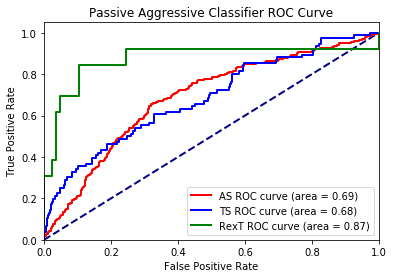

In [27]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_pac_roc_curve, 
                                'TS' : TS_pac_roc_curve, 
                                'RexT' : RexT_pac_roc_curve}, 
                 auc_dict={'AS' : AS_pac_roc_curve_AUC, 
                           'TS' : TS_pac_roc_curve_AUC, 
                           'RexT' : RexT_pac_roc_curve_AUC}, 
                 method_name='Passive Aggressive Classifier')

##### Check Alert Counts at Certain Threshold

##### Confusion Matrix

TP to FP ratio: 1.25


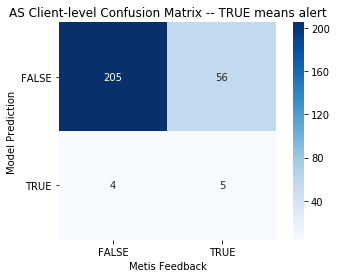

TP to FP ratio: 0.68


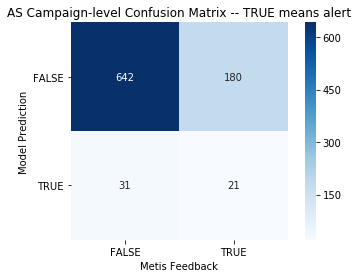

TP to FP ratio: 0.74


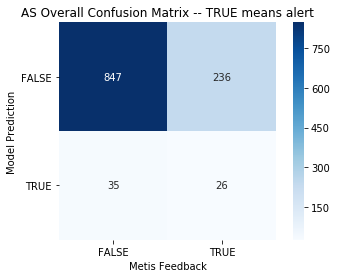

In [28]:
AS_threshold = 0.05
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 0], 
                        AS_pac_model.decision_function(AS_X_test[AS_X_test.is_campaign == 0]) >= AS_threshold, 
                              'AS Client-level')
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 1], 
                        AS_pac_model.decision_function(AS_X_test[AS_X_test.is_campaign == 1]) >= AS_threshold, 
                              'AS Campaign-level')
utils.confusion_matrix_visual(AS_y_test, 
                        AS_pac_model.decision_function(AS_X_test) >= AS_threshold, 'AS Overall')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


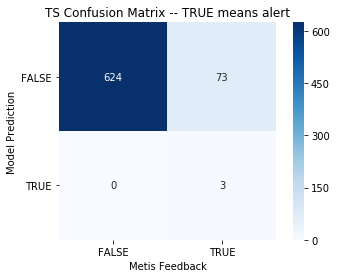

In [29]:
TS_threshold = 0.16
utils.confusion_matrix_visual(TS_y_test, 
                        TS_pac_model.decision_function(TS_X_test) >= TS_threshold,
                        'TS')

C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


TP to FP ratio: inf


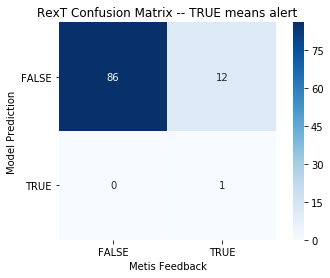

In [30]:
RexT_threshold = 0.1
utils.confusion_matrix_visual(RexT_y_test, 
                        RexT_pac_model.decision_function(RexT_X_test) >= RexT_threshold,
                        'RexT')

#### Metrics

In [31]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test, 
                                       'TS' : TS_y_test, 
                                       'RexT' : RexT_y_test},
                         y_pred_dict={'AS' : 
                                      AS_pac_model.decision_function(AS_X_test) >= AS_threshold, 
                                      'TS' : 
                                      TS_pac_model.decision_function(TS_X_test) >= TS_threshold, 
                                      'RexT' : 
                                      RexT_pac_model.decision_function(RexT_X_test) >= RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.78      0.96      0.86       882
       True       0.43      0.10      0.16       262

avg / total       0.70      0.76      0.70      1144

Percent misclassified: 23.69%
Count misclassified: 271
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.90      1.00      0.94       624
       True       1.00      0.04      0.08        76

avg / total       0.91      0.90      0.85       700

Percent misclassified: 10.43%
Count misclassified: 73
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.88      1.00      0.93        86
       True       1.00      0.08      0.14        13

avg / total       0.89      0.88      0.83        99

Percent misclassified: 12.12%
Count misclassified: 12
